### Required Discussion 16.1: Comparing Models

Now that you have seen a variety of models for regression and classification problems, it is good to step back and weigh the pros and cons of these options.  In the case of classification models, there are at least three things to consider:

1. Is the model good at handling imbalanced classes?
2. Does the model train quickly?
3. Does the model yield interpretable results?

Depending on your dataset and goals, the importance of these considerations will vary from project to project.  Your goal is to review our models to this point and discuss the pros and cons of each.  Two example datasets are offered as a way to offer two very different tasks where interpretability of the model may be of differing importance.

### Data and Task

Your goal is to discuss the pros and cons of Logistic Regression, Decision Trees, KNN, and SVM for the tasks below.  Consider at least the three questions above and list any additional considerations you believe are important to determining the "best" model for the task.  Share your response with your peers on the class discussion board.  

**TASK 1**: Predicting Customer Churn

Suppose you are tasked with producing a model to predict customer churn.  Which of your classification models would you use and what are the pros and cons of this model for this task?  Be sure to consider interpretability, imbalnced classes, and the speed of training.



In [27]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import time

In [28]:
from sklearn.datasets import load_digits

The data is loaded below.  Note that the handwritten digit data is already split into features and target (`digits`, `labels`). 

In [53]:
churn = pd.read_csv('data/telecom_churn.csv')
digits, labels = load_digits(return_X_y=True)

print(churn.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3333 non-null   object 
 1   Account length          3333 non-null   int64  
 2   Area code               3333 non-null   int64  
 3   International plan      3333 non-null   object 
 4   Voice mail plan         3333 non-null   object 
 5   Number vmail messages   3333 non-null   int64  
 6   Total day minutes       3333 non-null   float64
 7   Total day calls         3333 non-null   int64  
 8   Total day charge        3333 non-null   float64
 9   Total eve minutes       3333 non-null   float64
 10  Total eve calls         3333 non-null   int64  
 11  Total eve charge        3333 non-null   float64
 12  Total night minutes     3333 non-null   float64
 13  Total night calls       3333 non-null   int64  
 14  Total night charge      3333 non-null   

In [30]:
#churn data
churn.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [31]:
churn.dropna(inplace=True)
churn['International plan'] = np.where(churn['International plan'] == 'Yes', 1, 0)
churn['Voice mail plan'] = np.where(churn['Voice mail plan'] == 'Yes', 1, 0)
churn['Churn'] = np.where(churn['Churn'] == True, 1, 0)

churn.drop(columns=['State', 'Area code'], inplace=True)    

churn.head()

print(churn['Churn'].value_counts())


Churn
0    2850
1     483
Name: count, dtype: int64


In [32]:


churn.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Account length          3333 non-null   int64  
 1   International plan      3333 non-null   int64  
 2   Voice mail plan         3333 non-null   int64  
 3   Number vmail messages   3333 non-null   int64  
 4   Total day minutes       3333 non-null   float64
 5   Total day calls         3333 non-null   int64  
 6   Total day charge        3333 non-null   float64
 7   Total eve minutes       3333 non-null   float64
 8   Total eve calls         3333 non-null   int64  
 9   Total eve charge        3333 non-null   float64
 10  Total night minutes     3333 non-null   float64
 11  Total night calls       3333 non-null   int64  
 12  Total night charge      3333 non-null   float64
 13  Total intl minutes      3333 non-null   float64
 14  Total intl calls        3333 non-null   

In [33]:
fig, axes = plt.subplots(5, 4, figsize=(20, 18), dpi=500)
axes = axes.flatten()
fig.suptitle("Churn by Category", fontsize=25, fontweight="bold", y=1)

churn_samples = churn.sample(100)
for i, col in enumerate(churn_samples.columns):
    ax = axes[i]
    sns.countplot(data=churn_samples, x=col, hue="Churn", ax=ax, palette="Set2")
    ax.legend(frameon=True, facecolor="inherit", shadow=True)
    ax.set_title(f"Churn by {col}", fontsize=13)
    plt.tight_layout(pad=0.6)

    for i in ax.containers:
        ax.bar_label(i, fontsize=13)
plt.delaxes(ax=axes[-1])
plt.tight_layout()

In [50]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")

X_train, X_test, y_train, y_test = train_test_split(churn.drop(['Churn'], axis = 1), churn['Churn'], random_state = 42,
                                                   stratify = churn['Churn'])

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


extractor = SelectFromModel(LogisticRegression(penalty='l1', solver = 'liblinear',random_state = 42))
lgr_pipe = Pipeline([
                    ('selector', extractor),
                    ('lgr', LogisticRegression(random_state=42, max_iter=1000))])
                    
lgr_pipe.fit(X_train, y_train)
pipe_1_acc = lgr_pipe.score(X_test, y_test)

print("Number of features selected:", extractor.feature_names_in_.shape)

pipe_1_acc = lgr_pipe.score(X_test, y_test)
print("Accuracy of pipeline 1:", pipe_1_acc)



Training set shape: (2499, 17)
Testing set shape: (834, 17)
Number of features selected: (17,)
Accuracy of pipeline 1: 0.8633093525179856


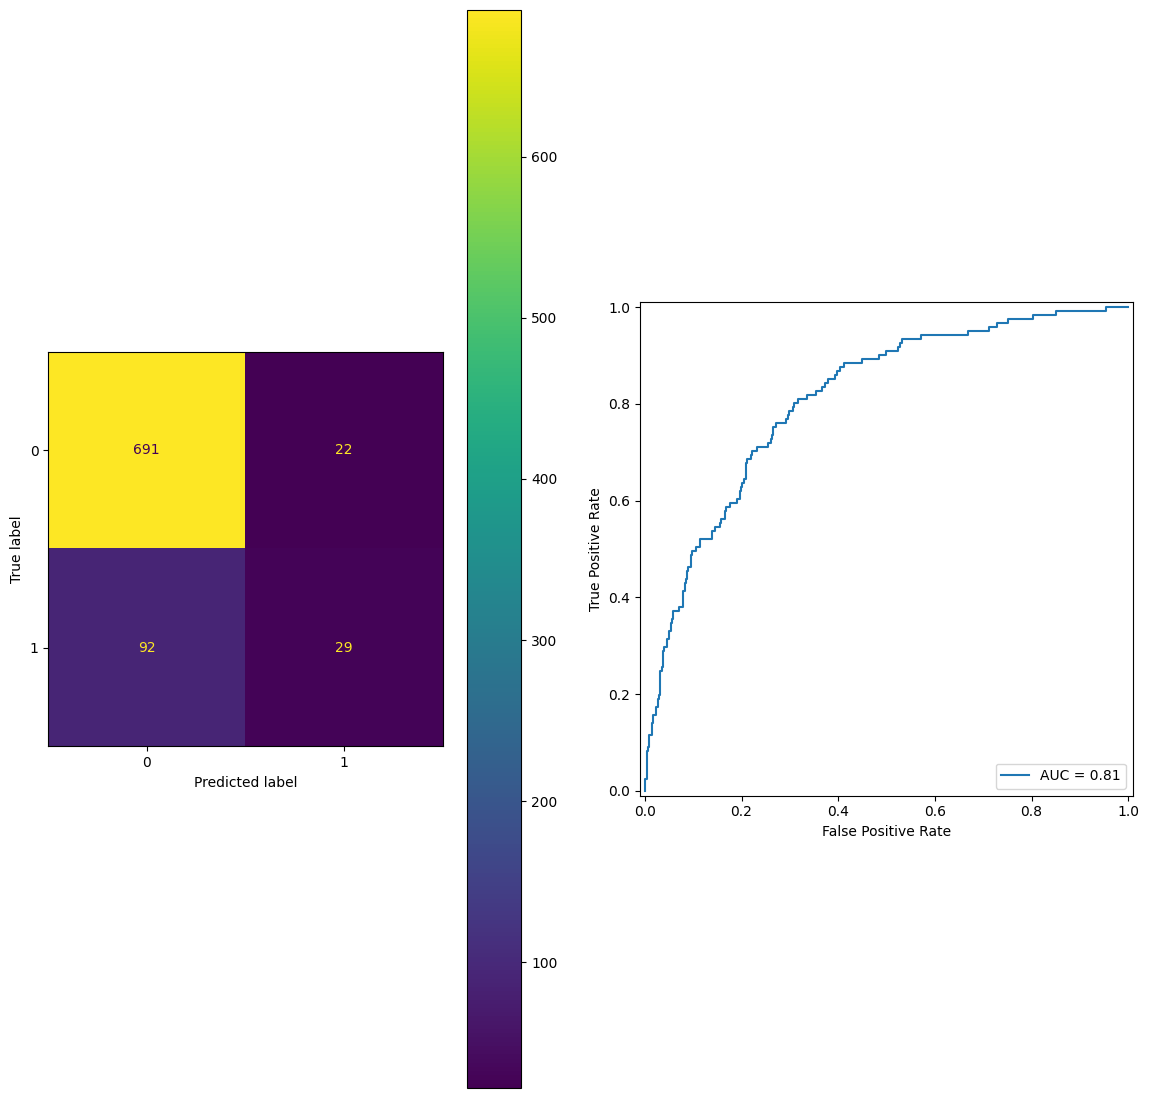

In [51]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

#confusion matrix
conf_matrix = confusion_matrix(y_test, lgr_pipe.predict(X_test))
fp = conf_matrix[0][1]
fn = conf_matrix[1][0]

#ROC Curve
y_score = lgr_pipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
auc = round(auc(fpr, tpr), 2)

#visualize
col1= ConfusionMatrixDisplay(conf_matrix)
col2 =RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(14, 14)

col1.plot(ax=ax[0])
col2.plot(ax=ax[1])


In [36]:

selected_features =extractor.feature_names_in_
clean_names = [i for i in selected_features]
coef_df = pd.DataFrame({'feature': clean_names, 'coefs': lgr_pipe.named_steps['lgr'].coef_[0]})
coef_df['coefs'] = coef_df['coefs'].apply(abs)
coef_df = coef_df.sort_values(by = 'coefs', ascending = False)
print(coef_df.head(10))

                   feature     coefs
1       International plan  1.924701
2          Voice mail plan  1.619900
16  Customer service calls  0.552880
14        Total intl calls  0.120038
13      Total intl minutes  0.077983
15       Total intl charge  0.056955
3    Number vmail messages  0.023170
12      Total night charge  0.020194
4        Total day minutes  0.013740
6         Total day charge  0.009237


In [37]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier().fit(X_train, y_train)
baseline_score = dummy_clf.score(X_test, y_test)
print(f'Baseline score: {baseline_score}')

svc = SVC().fit(X_train, y_train)
svc_defaults = svc.score(X_test, y_test)
print(f'SVC defaults: {svc_defaults}')


#We can use selective feature engineering to try and improve our model
#X_cols = ['International plan', 'Voice mail plan', 'Customer service calls', 'Total intl calls', 'Total intl minutes', 'Total intl charge', 'Number vmail messages', 'Total night charge']
#Y_cols = ['Churn']
#X_train, X_test, y_train, y_test = train_test_split(churn[X_cols], churn[Y_cols], test_size=0.2, random_state=42)


params = {'kernel': ['rbf', 'poly', 'linear', 'sigmoid']}

svc = SVC()
grid = GridSearchCV(svc, param_grid=params, cv=5)
grid.fit(X_train, y_train)

print(f'Best score: {grid.best_score_}')
print(f'Best params: {grid.best_params_}')

grid_score = grid.score(X_test, y_test)
print(f'Grid search score: {grid_score}')



Baseline score: 0.854916067146283
SVC defaults: 0.8561151079136691
Best score: 0.8551422845691382
Best params: {'kernel': 'rbf'}
Grid search score: 0.8561151079136691


In [38]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

linear= LinearRegression(fit_intercept=True).fit(X_train, y_train)
pipeline = Pipeline(steps=[('preprocessor', StandardScaler()),
                           ('linear', linear)])
pipeline.fit(X_train, y_train)

print(linear.coef_)

predictions = linear.predict(X_test)

print(f"Test MSE: {mean_squared_error(y_test, predictions):.2f}")
print(f"Test R2: {r2_score(y_test, predictions):.2f}")



[ 4.12447864e-03  8.86887412e-02 -6.47094100e-02  2.87630430e-02
  1.00630745e+01  7.63457656e-03 -9.99896357e+00  3.18956806e-01
  4.53810177e-03 -2.84813803e-01 -4.27263643e+00  1.43063513e-03
  4.28590206e+00 -1.90322105e+00 -2.57833008e-02  1.92610056e+00
  8.20041159e-02]
Test MSE: 788108.12
Test R2: -6353937.47


**TASK 2**: Recognizing Handwritten Digits

Suppose you are tasked with training a model to recognize handwritten digits.  Which of your classifier would you use here and why?  Again, be sure to consider the balance of classes, speed of training, and importance of interpretability.



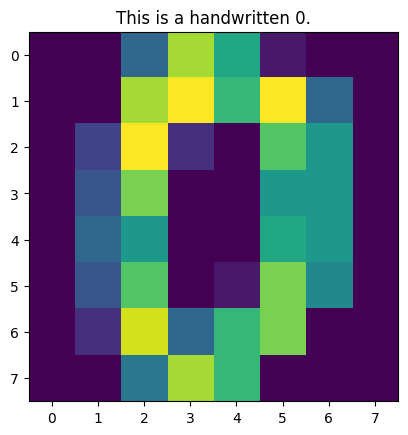

In [57]:
churn = pd.read_csv('data/telecom_churn.csv')
digits, labels = load_digits(return_X_y=True)

#example image
plt.imshow(digits[0].reshape(8, 8))
plt.title('This is a handwritten 0.');

In [58]:
X = churn.drop('Churn', axis=1)
y = churn.Churn

le = LabelEncoder()
y = le.fit_transform(y)

categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ]
)

models = {
    'KNN': (KNeighborsClassifier(), {'knn__n_neighbors': [3, 5, 7]}),
    'Logistic Regression': (LogisticRegression(max_iter=1000), {'logisticregression__C': [0.1, 1, 10]}),
    'SVC': (SVC(), {'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf']}),
    'Ridge Classifier': (RidgeClassifier(), {'ridgeclassifier__alpha': [0.1, 1, 10]}),
    'Lasso': (Lasso(max_iter=1000), {'lasso__alpha': [0.1, 1, 10]})
}




In [59]:


# Define features (X) and target (y)
X = churn.drop('Churn', axis=1)
y = churn['Churn']

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Identify categorical and numerical columns
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()


In [60]:
# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ])

# Define the models and hyperparameters
models = {
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': [3, 5, 7]}),
    'logisticregression': (LogisticRegression(max_iter=1000), {'logisticregression__C': [0.1, 1, 10]}),
    'svc': (SVC(), {'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf']}),
    'decisiontreeclassifier': (DecisionTreeClassifier(), {'decisiontreeclassifier__max_depth': [5, 10, 15]})
}

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = []

for name, (model, params) in models.items():
    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)
    ])
    
    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)
    
    # Fit the model and time it
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
    
    # Get the best estimator
    best_model = grid_search.best_estimator_
    
    # Evaluate on training and test sets
    train_score = best_model.score(X_train, y_train)
    test_score = best_model.score(X_test, y_test)
    
    # Append the results
    results.append([name, train_score, test_score, fit_time])

# Create the results DataFrame
results_df = pd.DataFrame(results, columns=['model', 'train score', 'test score', 'average fit time'])
results_df.set_index('model', inplace=True)

# Save to JSON (for submission if needed)
results_df.to_json('data/model_results.json')

In [61]:
df = pd.read_json(r'data/model_results.json')
df

,train score,test score,average fit time
knn,0.900600,0.874063,1.034676
logisticregression,0.870968,0.856072,0.441480
svc,0.991373,0.920540,0.259015
decisiontreeclassifier,0.957614,0.938531,0.044751


# Task 2:

                    train score  test score  average fit time
model                                                        
knn                    0.988170    0.969444          0.022566
logisticregression     0.998608    0.972222          0.027175
svc                    1.000000    0.980556          0.032741
decisiontree           1.000000    0.844444          0.017464


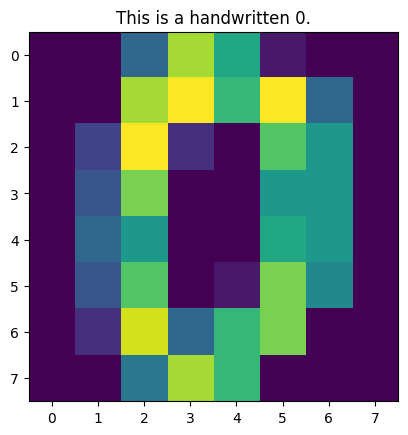

In [44]:

# Load dataset
digits = load_digits()
X, y = digits.data, digits.target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models and their hyperparameters
models = {
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': [3, 5, 7]}),
    'logisticregression': (LogisticRegression(max_iter=1000), {'logisticregression__C': [0.1, 1, 10]}),
    'svc': (SVC(), {'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf']}),
    'decisiontree': (DecisionTreeClassifier(), {'decisiontree__max_depth': [5, 10, 15]})
}

results = []

# Train and evaluate each model
for name, (model, params) in models.items():
    # Create a pipeline with StandardScaler and the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        (name, model)
    ])
    
    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)
    
    # Fit the model and time it
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
    
    # Get the best estimator
    best_model = grid_search.best_estimator_
    
    # Evaluate on training and test sets
    train_score = best_model.score(X_train, y_train)
    test_score = best_model.score(X_test, y_test)
    
    # Append the results
    results.append([name, train_score, test_score, fit_time])

# Create the results DataFrame
results_df = pd.DataFrame(results, columns=['model', 'train score', 'test score', 'average fit time'])
results_df.set_index('model', inplace=True)

# Display the DataFrame
print(results_df)

# Plot an example image
import matplotlib.pyplot as plt
plt.imshow(digits.images[0], cmap='viridis')
plt.title('This is a handwritten 0.')
plt.show()


Model Accuracy with PCA-enhanced KNN: 83.70%
         PC1        PC2       PC3        PC4        PC5       PC6       PC7  \
0  -1.259466 -21.274883  9.463055 -13.014189   7.128823  7.440659 -3.252837   
1   7.957611  20.768699 -4.439506  14.893664  -5.896249  6.485622 -2.126228   
2   6.991923   9.955986 -2.958558  12.288302  18.126023  4.507664 -1.843122   
3 -15.906105  -3.332464 -9.824372  12.275838  -6.965169 -1.089483  1.042085   
4  23.306867  -4.269061  5.675129  13.851524   0.358124  2.857574  0.720497   

         PC8       PC9       PC10  ...      PC21      PC22      PC23  \
0  -2.553470  0.581842  -3.625697  ...  2.680850  1.009450  2.009703   
1   4.615936 -3.587450   1.074705  ... -1.205777 -4.838902  0.860251   
2  16.415200 -0.719233  -4.255805  ...  4.951115 -2.465109  5.999388   
3 -10.973556  3.259735  -6.498753  ...  0.269413  3.623236  2.538124   
4 -13.041696  3.835413 -13.414164  ...  0.206830  5.740696 -7.611946   

       PC24      PC25      PC26      PC27      

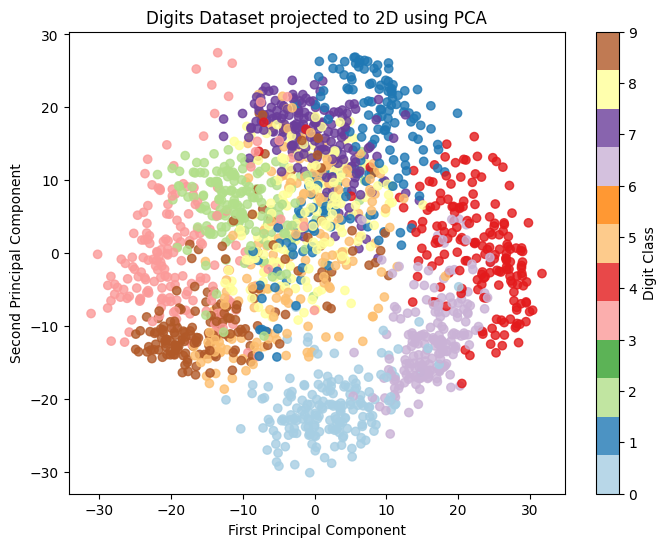

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd

# 1. Load the digits dataset
digits = load_digits()
X = digits.data
y = digits.target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Build a pipeline for scaling, PCA, and KNN
# Using a pipeline ensures the same transformations are applied consistently
# to both training and test data.
# We choose to reduce the dimensions to 30 principal components
# (a good balance of variance explained vs. dimensionality reduction)
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('pca', PCA(n_components=5)), # Reduce to 30 components
    ('knn', KNeighborsClassifier(n_neighbors=2)) # KNN classifier
])

# 3. Train the model (fit the pipeline to the training data)
# The fit method handles scaling and PCA fitting/transforming internally
pipeline.fit(X_train, y_train)

# 4. Evaluate the model on the test data
# The score method handles the transformation of the test data internally before predicting
accuracy = pipeline.score(X_test, y_test)
print(f"Model Accuracy with PCA-enhanced KNN: {accuracy*100:.2f}%")

# 5. Optional: Visualize the digits in 2D space using PCA
pca_2d = PCA(n_components=30)
# Transform the entire dataset for visualization purposes
X_projected = pca_2d.fit_transform(X)

print(pd.DataFrame(X_projected, columns=[f'PC{i+1}' for i in range(30)]).head())

plt.figure(figsize=(8, 6))
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=y, cmap='Paired', alpha=0.8)
plt.colorbar(label='Digit Class')
plt.title('Digits Dataset projected to 2D using PCA')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()